In [1]:
%pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("biaiscience/dogs-vs-cats")

print("Path to dataset files:", path)

100%|██████████| 817M/817M [00:07<00:00, 118MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/biaiscience/dogs-vs-cats/versions/1


In [3]:
import os
import pathlib


In [4]:

# Define the path to your dataset
data_dir = pathlib.Path("/root/.cache/kagglehub/datasets/biaiscience/dogs-vs-cats/versions/1")

# Check if the path exists
if data_dir.exists():
    print("Directory exists!")
    
    # List the contents (should be a bunch of image files)
    image_count = len(list(data_dir.glob('*.jpg')))
    print(f"Number of images: {image_count}")
    
    # Let's see the first 10 files
    print("Sample files:")
    for filepath in data_dir.glob('*.jpg'):
        print(filepath.name)
        break  # Just show the first one to check the naming pattern
else:
    print("Directory not found. Check the path.")

Directory exists!
Number of images: 0
Sample files:


In [5]:
import os
from pathlib import Path

# Define the base path
base_dir = Path("/root/.cache/kagglehub/datasets/biaiscience/dogs-vs-cats/versions/1")

# Recursively list all files and directories
print("Exploring directory structure...")
for root, dirs, files in os.walk(base_dir):
    level = root.replace(str(base_dir), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        if file.endswith(('.jpg', '.jpeg', '.png')):
            print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')
    
    # If we find image files, we can break early
    if any(file.endswith(('.jpg', '.jpeg', '.png')) for file in files):
        print(f"\nFound images in: {root}")
        break

Exploring directory structure...
1/
  train/
    train/
      dog.8050.jpg
      dog.1720.jpg
      dog.9826.jpg
      dog.8535.jpg
      cat.12016.jpg
      ... and 24995 more files

Found images in: /root/.cache/kagglehub/datasets/biaiscience/dogs-vs-cats/versions/1/train/train


In [6]:
data_dir = pathlib.Path("/root/.cache/kagglehub/datasets/biaiscience/dogs-vs-cats/versions/1/train/train")

print(f"Total images: {len(list(data_dir.glob('*.jpg')))}")
print(f"Cat images: {len(list(data_dir.glob('cat*.jpg')))}")
print(f"Dog images: {len(list(data_dir.glob('dog*.jpg')))}")

Total images: 25000
Cat images: 12500
Dog images: 12500


In [7]:
import shutil

def organize_cats_dogs_dataset(source_dir, target_dir):
    """
    Organize the dataset into proper class folders
    """
    # Create target directory structure
    train_dir = target_dir / 'train'
    val_dir = target_dir / 'validation'
    
    for split_dir in [train_dir, val_dir]:
        for class_name in ['cats', 'dogs']:
            (split_dir / class_name).mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    image_files = list(source_dir.glob('*.jpg'))
    print(f"Found {len(image_files)} images")
    
    # Split into cats and dogs
    cat_files = [f for f in image_files if f.name.startswith('cat')]
    dog_files = [f for f in image_files if f.name.startswith('dog')]
    
    print(f"Cats: {len(cat_files)}, Dogs: {len(dog_files)}")
    
    # Split each class into train/validation (80/20)
    from sklearn.model_selection import train_test_split
    
    cat_train, cat_val = train_test_split(cat_files, test_size=0.2, random_state=42)
    dog_train, dog_val = train_test_split(dog_files, test_size=0.2, random_state=42)
    
    # Copy files to organized structure
    def copy_files(files, destination, class_name):
        for file in files:
            shutil.copy2(file, destination / class_name / file.name)
    
    print("Organizing dataset...")
    copy_files(cat_train, train_dir, 'cats')
    copy_files(cat_val, val_dir, 'cats')
    copy_files(dog_train, train_dir, 'dogs')
    copy_files(dog_val, val_dir, 'dogs')
    
    print("Dataset organization completed!")
    return train_dir.parent

# Organize the dataset
organized_dir = pathlib.Path("/root/.cache/kagglehub/datasets/biaiscience/dogs-vs-cats/versions/1/organized")
organized_data_dir = organize_cats_dogs_dataset(data_dir, organized_dir)

Found 25000 images
Cats: 12500, Dogs: 12500
Organizing dataset...
Dataset organization completed!


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)


2025-09-22 14:22:52.812763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 14:22:52.812869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 14:22:53.003439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 14:22:53.435021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 14:22:55.576723: W tensorflow/compiler/tf2

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [10]:
train_generator = train_datagen.flow_from_directory(
    organized_data_dir / 'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # binary classification
    shuffle=True
)

val_generator = validation_datagen.flow_from_directory(
    organized_data_dir / 'validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [11]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Training samples: 20000
Validation samples: 5000
Class indices: {'cats': 0, 'dogs': 1}


In [12]:
# Core libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.regularizers import l2    

# For visualization and analysis
import matplotlib.pyplot as plt
import numpy as np

# For file operations and utilities
import os
from pathlib import Path

# For additional metrics (optional)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  # For better confusion matrix visualization

In [ ]:
Model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Flatten(),

    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification

])

Model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
                metrics=['accuracy'])

Model.summary()

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = Model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 186624)            0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [17]:
Model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),


    Flatten(),


    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.25),

    Dense(1, activation='sigmoid')  # Binary classification

])

Model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
                metrics=['accuracy'])

Model.summary()

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = Model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [18]:
from tensorflow.keras.layers import Activation

In [19]:
Model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),


    Flatten(),


    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.25),

    Dense(1, activation='sigmoid')  # Binary classification

])

Model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
                metrics=['accuracy'])

Model.summary()

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = Model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)     

2025-09-22 15:37:32.565515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 62s 85ms/step - loss: 0.7246 - accuracy: 0.5639 - val_loss: 0.6861 - val_accuracy: 0.5411
Epoch 2/30
625/625 [==============================] - 47s 74ms/step - loss: 0.6379 - accuracy: 0.6098 - val_loss: 0.6020 - val_accuracy: 0.6508
Epoch 3/30
625/625 [==============================] - 45s 73ms/step - loss: 0.6011 - accuracy: 0.6633 - val_loss: 0.6214 - val_accuracy: 0.6322
Epoch 4/30
625/625 [==============================] - 45s 72ms/step - loss: 0.5731 - accuracy: 0.6954 - val_loss: 0.6906 - val_accuracy: 0.6192
Epoch 5/30
625/625 [==============================] - 46s 74ms/step - loss: 0.5497 - accuracy: 0.7206 - val_loss: 0.6153 - val_accuracy: 0.6364
Epoch 6/30
625/625 [==============================] - 46s 74ms/step - loss: 0.5313 - accuracy: 0.7365 - val_loss: 0.5621 - val_accuracy: 0.7073
Epoch 7/30
625/625 [==============================] - 44s 71ms/step - loss: 0.5102 - accuracy: 0.7516 - val_loss: 0.5826 - val_accuracy: 0.6775
Epo

In [22]:
Model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),


    Flatten(),


    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.6),


    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')  # Binary classification

])

Model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
                metrics=['accuracy'])

Model.summary()

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train the model
history = Model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_22 (Ba  (None, 222, 222, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 64)     

2025-09-22 16:57:28.382494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 51s 74ms/step - loss: 0.6941 - accuracy: 0.5821 - val_loss: 0.6600 - val_accuracy: 0.6172
Epoch 2/60
625/625 [==============================] - 44s 70ms/step - loss: 0.5805 - accuracy: 0.6888 - val_loss: 0.5570 - val_accuracy: 0.7224
Epoch 3/60
625/625 [==============================] - 44s 70ms/step - loss: 0.5174 - accuracy: 0.7472 - val_loss: 0.6216 - val_accuracy: 0.6691
Epoch 4/60
625/625 [==============================] - 50s 80ms/step - loss: 0.4597 - accuracy: 0.7890 - val_loss: 0.6646 - val_accuracy: 0.6649
Epoch 5/60
625/625 [==============================] - 47s 74ms/step - loss: 0.4079 - accuracy: 0.8148 - val_loss: 0.4095 - val_accuracy: 0.8173
Epoch 6/60
625/625 [==============================] - 47s 75ms/step - loss: 0.3700 - accuracy: 0.8395 - val_loss: 0.3473 - val_accuracy: 0.8548
Epoch 7/60
625/625 [==============================] - 46s 74ms/step - loss: 0.3386 - accuracy: 0.8557 - val_loss: 0.3337 - val_accuracy: 0.8622
Epo

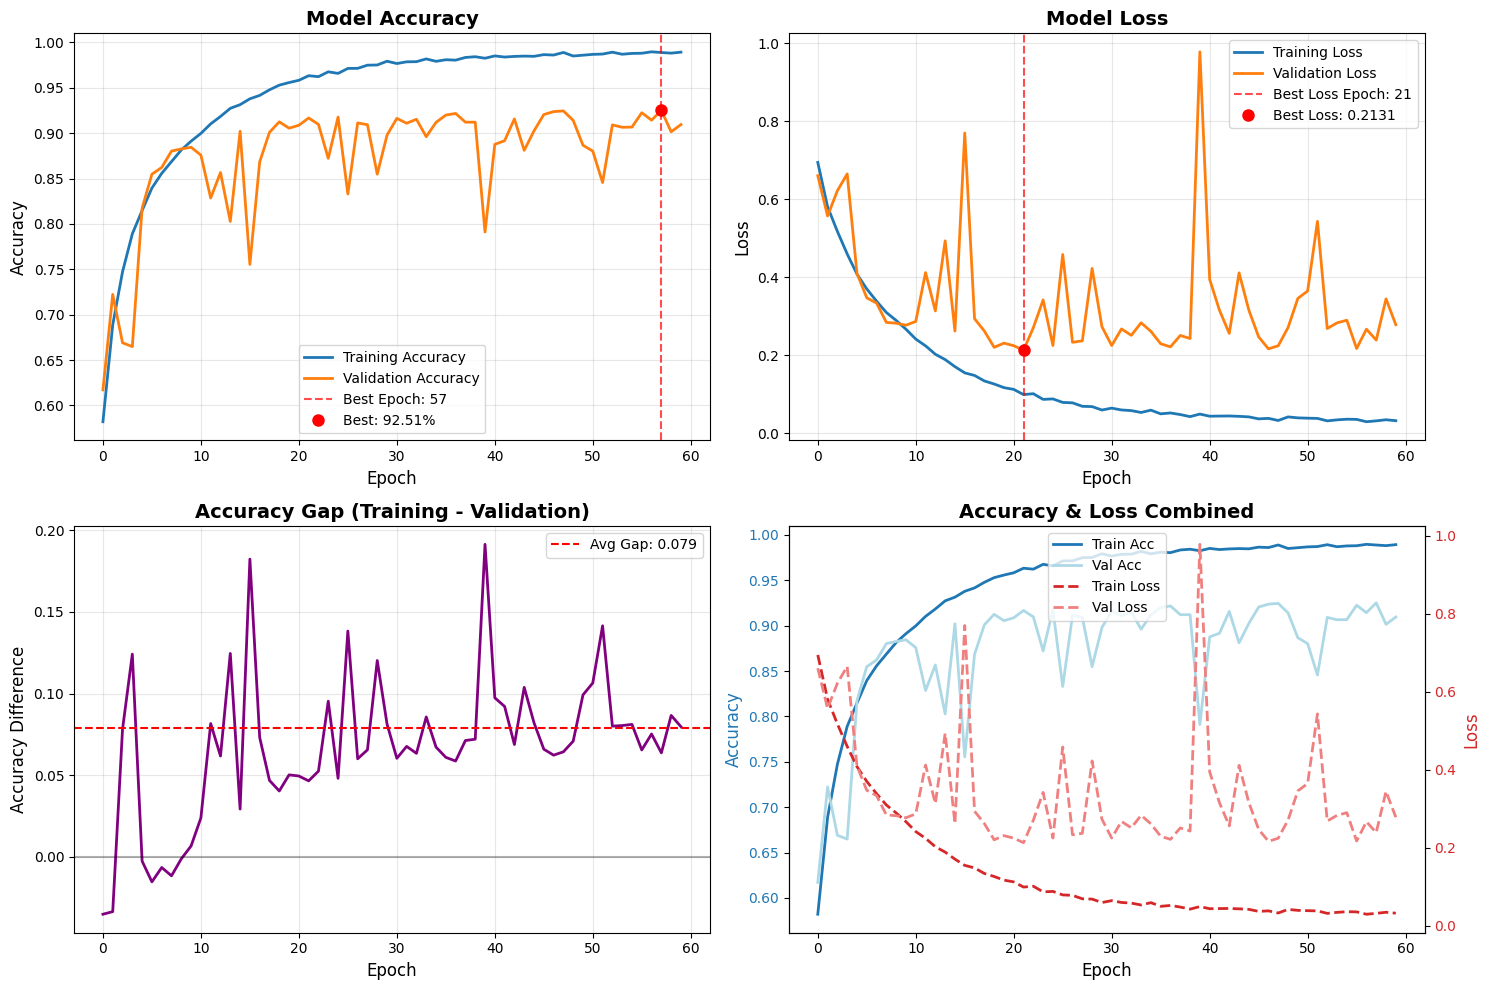

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2x2 subplots for comprehensive analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Accuracy Plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Mark the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])
best_acc = history.history['val_accuracy'][best_epoch]
ax1.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch}')
ax1.plot(best_epoch, best_acc, 'ro', markersize=8, label=f'Best: {best_acc:.2%}')
ax1.legend()

# 2. Loss Plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Mark the best validation loss
best_loss_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_loss_epoch]
ax2.axvline(x=best_loss_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Loss Epoch: {best_loss_epoch}')
ax2.plot(best_loss_epoch, best_loss, 'ro', markersize=8, label=f'Best Loss: {best_loss:.4f}')
ax2.legend()

# 3. Accuracy Difference (Overfitting Measure)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_gap = [train_acc[i] - val_acc[i] for i in range(len(train_acc))]

ax3.plot(accuracy_gap, color='purple', linewidth=2)
ax3.set_title('Accuracy Gap (Training - Validation)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Accuracy Difference', fontsize=12)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.grid(True, alpha=0.3)

# Add average gap line
avg_gap = np.mean(accuracy_gap[10:])  # Skip first 10 epochs
ax3.axhline(y=avg_gap, color='red', linestyle='--', 
            label=f'Avg Gap: {avg_gap:.3f}')
ax3.legend()

# 4. Combined View (Dual Y-axis)
ax4_primary = ax4
ax4_secondary = ax4.twinx()

# Primary axis (Accuracy)
color1 = 'tab:blue'
ax4_primary.set_xlabel('Epoch', fontsize=12)
ax4_primary.set_ylabel('Accuracy', color=color1, fontsize=12)
ax4_primary.plot(history.history['accuracy'], color=color1, linewidth=2, label='Train Acc')
ax4_primary.plot(history.history['val_accuracy'], color='lightblue', linewidth=2, label='Val Acc')
ax4_primary.tick_params(axis='y', labelcolor=color1)

# Secondary axis (Loss)
color2 = 'tab:red'
ax4_secondary.set_ylabel('Loss', color=color2, fontsize=12)
ax4_secondary.plot(history.history['loss'], color=color2, linewidth=2, linestyle='--', label='Train Loss')
ax4_secondary.plot(history.history['val_loss'], color='lightcoral', linewidth=2, linestyle='--', label='Val Loss')
ax4_secondary.tick_params(axis='y', labelcolor=color2)

ax4_primary.set_title('Accuracy & Loss Combined', fontsize=14, fontweight='bold')

# Combine legends
lines1, labels1 = ax4_primary.get_legend_handles_labels()
lines2, labels2 = ax4_secondary.get_legend_handles_labels()
ax4_primary.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.show()

In [24]:
# Performance Summary Statistics
print("=== TRAINING PERFORMANCE SUMMARY ===")
print(f"Best Validation Accuracy: {best_acc:.2%} (Epoch {best_epoch + 1})")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.2%}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.2%}")
print(f"Average Accuracy Gap: {avg_gap:.3f} ({avg_gap*100:.1f}%)")
print(f"Best Validation Loss: {best_loss:.4f} (Epoch {best_loss_epoch + 1})")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Epoch-wise Performance Table (Last 10 epochs)
print("\n=== LAST 10 EPOCHS PERFORMANCE ===")
print("Epoch | Train Acc | Val Acc  | Train Loss | Val Loss")
print("-" * 55)
for i in range(max(0, len(history.history['accuracy'])-10), len(history.history['accuracy'])):
    print(f"{i+1:5d} | {history.history['accuracy'][i]:.3f}    | {history.history['val_accuracy'][i]:.3f}    | "
          f"{history.history['loss'][i]:.4f}    | {history.history['val_loss'][i]:.4f}")

=== TRAINING PERFORMANCE SUMMARY ===
Best Validation Accuracy: 92.51% (Epoch 58)
Final Validation Accuracy: 90.95%
Final Training Accuracy: 98.92%
Average Accuracy Gap: 0.079 (7.9%)
Best Validation Loss: 0.2131 (Epoch 22)
Final Validation Loss: 0.2784

=== LAST 10 EPOCHS PERFORMANCE ===
Epoch | Train Acc | Val Acc  | Train Loss | Val Loss
-------------------------------------------------------
   51 | 0.987    | 0.880    | 0.0390    | 0.3648
   52 | 0.987    | 0.846    | 0.0384    | 0.5431
   53 | 0.989    | 0.909    | 0.0321    | 0.2686
   54 | 0.987    | 0.906    | 0.0347    | 0.2831
   55 | 0.988    | 0.907    | 0.0363    | 0.2899
   56 | 0.988    | 0.922    | 0.0359    | 0.2173
   57 | 0.990    | 0.914    | 0.0299    | 0.2669
   58 | 0.989    | 0.925    | 0.0321    | 0.2390
   59 | 0.988    | 0.901    | 0.0349    | 0.3446
   60 | 0.989    | 0.909    | 0.0325    | 0.2784


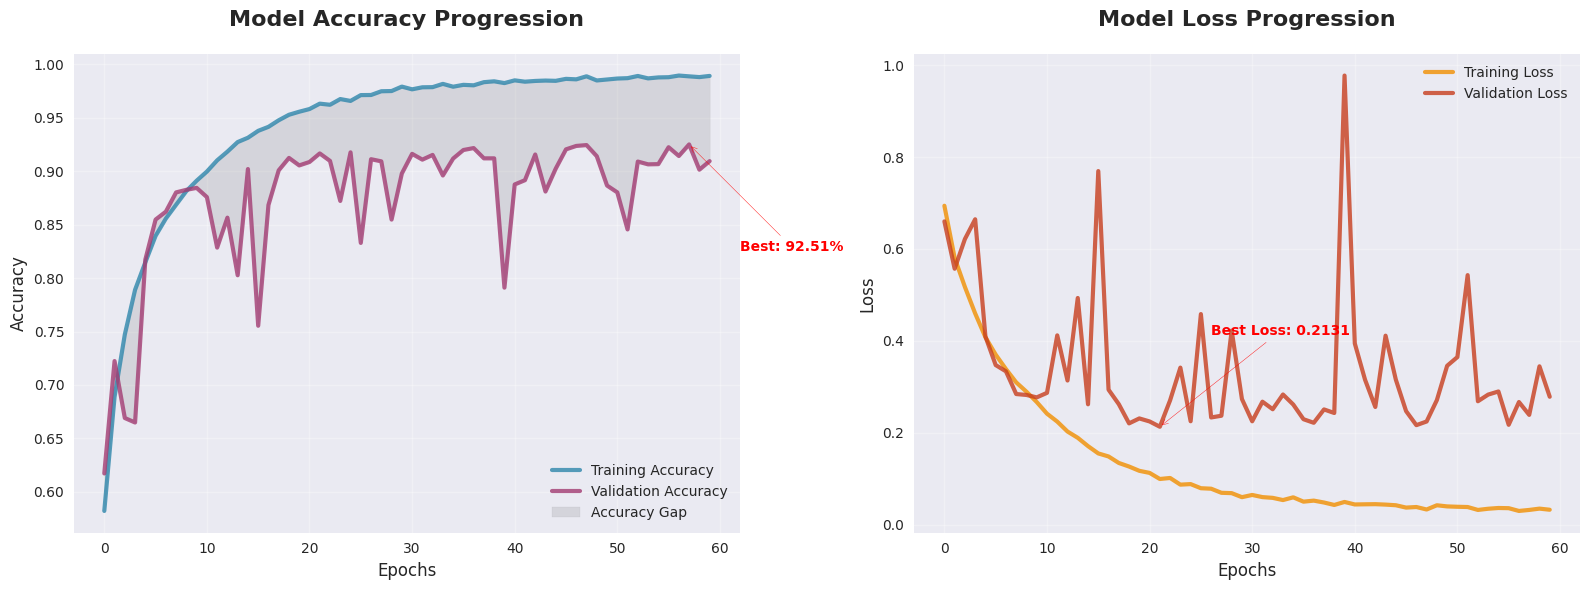

In [25]:
# More professional-looking graph with custom styling
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stylized Accuracy Plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', 
         color='#2E86AB', linewidth=3, alpha=0.8)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', 
         color='#A23B72', linewidth=3, alpha=0.8)
ax1.fill_between(range(len(history.history['accuracy'])),
                 history.history['accuracy'], history.history['val_accuracy'],
                 alpha=0.2, color='gray', label='Accuracy Gap')
ax1.set_title('Model Accuracy Progression', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Annotate best accuracy
ax1.annotate(f'Best: {best_acc:.2%}', xy=(best_epoch, best_acc), 
             xytext=(best_epoch+5, best_acc-0.1),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red', fontweight='bold')

# Stylized Loss Plot
ax2.plot(history.history['loss'], label='Training Loss', 
         color='#F18F01', linewidth=3, alpha=0.8)
ax2.plot(history.history['val_loss'], label='Validation Loss', 
         color='#C73E1D', linewidth=3, alpha=0.8)
ax2.set_title('Model Loss Progression', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Annotate best loss
ax2.annotate(f'Best Loss: {best_loss:.4f}', xy=(best_loss_epoch, best_loss), 
             xytext=(best_loss_epoch+5, best_loss+0.2),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red', fontweight='bold')

plt.tight_layout()
plt.show()